In [1]:
from pyeeg.solvers import *
from pyeeg.solvers import _svd_regress, _lstsq_regress
from pyeeg.simulate import simulate_pulse_inputs, simulate_trf_output, dummy_trf_kernel
from pyeeg.utils import lag_matrix, lag_matrix_
import matplotlib.pyplot as plt

INFO:pyeeg:Successfully loaded makeRateMap_c Python extension module.
INFO:pyeeg:Successfully loaded gammatone_c Python extension module.
c:\Users\hugwei\Anaconda3\envs\sandbox\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pyeeg.solvers'

In [2]:
A = np.array([[4, 1], [1, 3]])
b = np.array([1, 2])
A = np.random.rand(5, 5)
# A bit of multicolinearity in A, not rank deficient though, but towards ill-conditioning
A[0] = A[2] * 0.1 + np.random.rand(5)
A = A @ A.T
b = np.random.rand(5)
x0 = np.zeros_like(b)
# Regularised solutions
cg_solution = conjugate_gradient(A, b, x0, lambda_=.00001)
svd_solution = svd_solver(A, b, lambda_=0.00001)
assert np.allclose(cg_solution, svd_solution), "Conjugate gradient and SVD solutions do not match."
# Unregularised solutions
pseudo_inverse_solution = np.linalg.pinv(A) @ b
cg_solution = conjugate_gradient(A, b, x0, lambda_=0.0)
svd_truncated_solution = svd_solver(A, b, lambda_=1-1e-8, truncated_svd=True, verbose=True)
assert np.allclose(pseudo_inverse_solution, svd_truncated_solution), "Pseudo inverse and SVD truncated solutions do not match."
assert np.allclose(cg_solution, svd_truncated_solution), "Conjugate gradient and SVD truncated solutions do not match."

Keeping 5 components (out of 5)
Variance explained: 1.0
Singular values: [7.85436685e+00 8.42657940e-01 6.83365734e-01 1.20323210e-01
 6.42334219e-04]


In [3]:
from pyeeg import TRFEstimator

In [4]:
tker, ker = dummy_trf_kernel()
t, x = simulate_pulse_inputs()
y = simulate_trf_output(tker, ker, x).copy()
srate = 100
lags = np.round(tker * srate).astype(int)
X = lag_matrix(x, lags, filling=0., drop_missing=False).copy()

C:\Users\hugwei\AppData\Local\Temp\ipykernel_21680\424680249.py:6: DeprecationWarning: The filling argument is deprecated and will be removed in future versions. See lag_matrix docstring for more info.
  X = lag_matrix(x, lags, filling=0., drop_missing=False).copy()
C:\Users\hugwei\AppData\Local\Temp\ipykernel_21680\424680249.py:6: DeprecationWarning: The drop_missing argument is deprecated and will be removed in future versions. See lag_matrix docstring for more info.
  X = lag_matrix(x, lags, filling=0., drop_missing=False).copy()


In [7]:
y.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [ ]:
X.T@y

: 

In [6]:
XX, XY = X.T@X, X.T @ y


: 

In [ ]:

# Unregularised solutions
pseudo_inverse_solution = np.linalg.pinv(XX) @ XY
cg_solution = conjugate_gradient(XX, XY, np.zeros_like(XY), lambda_=0.0)
svd_solution = svd_solver(XX, XY, lambda_=0., truncated_svd=False, verbose=False)
# trf_solution = _svd_regress(X.copy(), y[:, None], alpha=0.)
trf_solution = _lstsq_regress(XX, XY)
# TRFEstimator(times=tker, srate=100).fit(X, y[:, None]).coef_.squeeze()

In [1]:
plt.plot(tker, ker)
plt.plot(tker, cg_solution, label='CG')
plt.plot(tker, pseudo_inverse_solution, label='CG')
plt.plot(tker, svd_solution, label='CG')
plt.plot(tker, trf_solution, label='CG')
plt.plot(tker, TRFEstimator(times=tker, srate=100).fit(x[:, None], y[:, None]).coef_.squeeze())
plt.plot(tker, TRFEstimator(times=tker, srate=100, fit_intercept=False).fit(X[:, ::-1], y[:, None], lagged=True, drop=False).coef_.squeeze())

NameError: name 'plt' is not defined

In [15]:
import numpy as np
from pyeeg.utils import lag_matrix
    
def lag_matrix_np(x, lags, mode='valid', fill_value=0):
    x = np.atleast_2d(np.asarray(x))
    if x.shape[0] == 1:
        x = x.T
    if x.shape[1] > 1:
        return np.concatenate([lag_matrix_np(x[:, i], lags, mode=mode, fill_value=fill_value) for i in range(x.shape[1])], axis=1)
    x = x.squeeze()
    n = len(x)
    lags = -np.asarray(lags) #TODO: minus signs to match expected behavior from TRFEstimator: maybe change in future
    min_lag, max_lag = lags.min(), lags.max()

    # Always compute full matrix first
    X_full = np.full((n, len(lags)), fill_value, dtype=x.dtype)

    for i, lag in enumerate(lags):
        if lag < 0:
            X_full[-lag:, i] = x[:n + lag]
        else:
            X_full[:n - lag, i] = x[lag:]

    if mode == 'full':
        return X_full
    elif mode == 'valid':
        start = max(0, -min_lag)
        end = n - max_lag
        return X_full[start:end]
    else:
        raise ValueError("mode must be 'valid' or 'full'")

In [21]:
data = np.asarray([[1,2,3,4,5,6],[7,8,9,10,11,12]]).T
out = lag_matrix_np(data, (-1, 0, 2), mode='full')

In [22]:
out

array([[ 2,  1,  0,  8,  7,  0],
       [ 3,  2,  0,  9,  8,  0],
       [ 4,  3,  1, 10,  9,  7],
       [ 5,  4,  2, 11, 10,  8],
       [ 6,  5,  3, 12, 11,  9],
       [ 0,  6,  4,  0, 12, 10]])

In [250]:
tker, ker = dummy_trf_kernel()
t, x = simluate_pulse_inputs()
y = simulate_trf_output(tker, ker, x)
lags = np.round(tker * 100).astype(int)
X = lag_matrix_np(x, lags, mode='full')
# X = lag_matrix_np2(x, -lags, mode='full')
# X = lag_matrix(x, lags, filling=0., drop_missing=False)

In [256]:
svd_solver(X.T@X, X.T@y)

: 

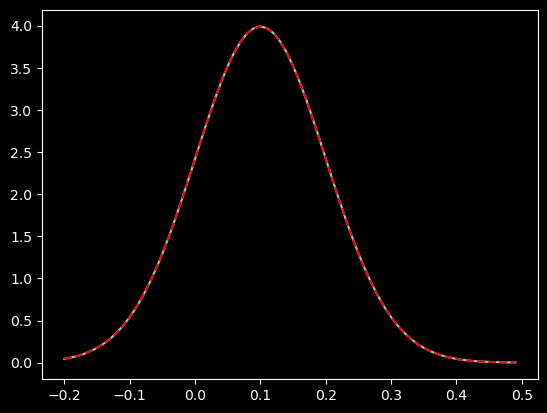

In [253]:
plt.plot(tker, np.linalg.lstsq(X, y[:, None], rcond=None)[0])
plt.plot(tker, ker, 'r--')

INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Computing statistics...
INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Computing statistics...


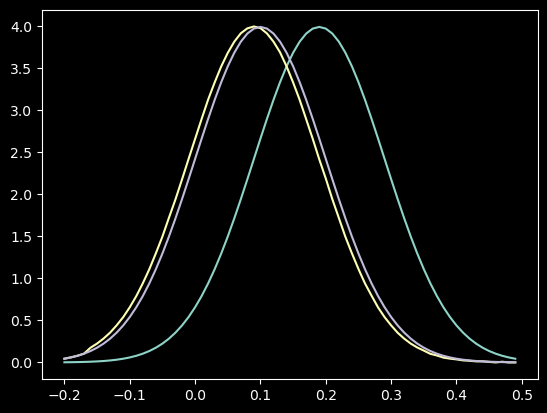

In [223]:
trf = TRFEstimator(times=tker, srate=100)
trf.fit(X, y[:, None], lagged=True, drop=False)
fig = trf.plot();
trf.fit(x[:, None], y[:, None], lagged=False, drop=False)
trf.plot(ax=fig.gca());
ax = fig.gca()
ax.plot(tker, ker)

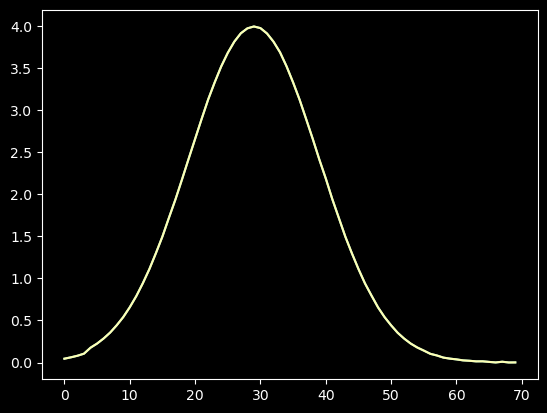

In [159]:
plt.plot(b2)
plt.plot(b)

In [158]:
b = np.linalg.inv(X.T@X + 0.0001*np.eye(70)) @ X.T @ y
b2 = np.linalg.pinv(X) @ y
assert np.allclose(b, b2, atol=1e-4), "Lagged matrix regression coefficients do not match."

In [31]:
x = np.arange(8)
X_full = lag_matrix_np(x, lags[::-1], mode='full')
X_full_old = lag_matrix(x, lags, drop_missing=False, filling=0)
print(X_full)

[[2 0 0]
 [3 1 0]
 [4 2 1]
 [5 3 2]
 [6 4 3]
 [7 5 4]
 [0 6 5]
 [0 7 6]]


In [46]:
K = np.array([1., 0.5, 0.2, -0.1])

In [52]:
Y = X_full_test @ K

In [60]:
X_full

array([[2, 1, 0, 0],
       [3, 2, 1, 0],
       [4, 3, 2, 1],
       [5, 4, 3, 2],
       [0, 5, 4, 3]])

In [63]:
x = np.array([1, 2, 3, 4, 5])
lags = np.array([-1, 0, 1, 2])
# Test lag_matrix_np function
X_valid = lag_matrix_np(x, -lags, mode='valid')
X_full = lag_matrix_np(x, -lags, mode='full')
# Test lag_matrix function
X_valid_test = lag_matrix(x, lags, drop_missing=True)
X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

# Check if the results are the same
assert np.array_equal(X_valid, X_valid_test), "Valid mode results do not match."
assert np.array_equal(X_full, X_full_test), "Full mode results do not match."

### Performance test

In [17]:
# Test lag_matrix_np function
%timeit X_valid = lag_matrix_np(x, lags, mode='valid')
%timeit X_full = lag_matrix_np(x, lags, mode='full')
# Test lag_matrix function
%timeit X_valid_test = lag_matrix(x, lags, drop_missing=True)
%timeit X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

9.94 μs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11 μs ± 340 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.14 ms ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
771 μs ± 22.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
# Large array test
x = np.random.rand(10000)
lags = np.arange(-100, 101, 1)
# Test lag_matrix_np function
%timeit X_valid = lag_matrix_np(x, lags, mode='valid')
%timeit X_full = lag_matrix_np(x, lags, mode='full')
# Test lag_matrix function
%timeit X_valid_test = lag_matrix(x, lags, drop_missing=True)
%timeit X_full_test = lag_matrix(x, lags, drop_missing=False, filling=0)

8.14 ms ± 195 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.93 ms ± 204 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
60.3 ms ± 454 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.3 ms ± 279 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Example simulation TRF

In [ ]:
from pyeeg.simulate import dummy_trf_kernel, simulate_pulse_inputs, simulate_trf_output
from pyeeg import TRFEstimator
from pyeeg.utils import lag_matrix
import matplotlib.pyplot as plt
import numpy as np

In [22]:
tker, ker = dummy_trf_kernel(kernel_type='bipolar')
# ker = np.diff(np.r_[ker[0], ker])

t, x = simulate_pulse_inputs()
y = simulate_trf_output(tker, ker, x)

trf = TRFEstimator(tmin=-0.2, tmax=0.4, srate=100)
trf.fill_lags()
lags = trf.lags
x_lagged = lag_matrix(x, lags[::-1], drop_missing=True)
# x_lagged = lag_matrix_np(x, lags, mode='valid')
trf.fit(x_lagged, y[:, None], lagged=True)


f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(tker, ker, label='True kernel')
trf.plot(ax=ax[0], plot_kws=dict(label='TRF estimate', ls='--'))
ax[0].legend()
ax[0].set_xlabel('Time lag (s)')
ax[1].plot(t, y, label='output', c='C3')
ax[1].plot(t, x, label='input', c='C2')
ax[1].legend()
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([0, 3])

NameError: name 'simulate_pulse_inputs' is not defined